# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with an `OpflowQNN`
    * Classification with a `CircuitQNN`
    * Variational Quantum Classifier (`VQC`)
    
    
2. [Regression](#Regression)
    * Regression with an `OpflowQNN`
    * Variational Quantum Regressor (`VQR`)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [31]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

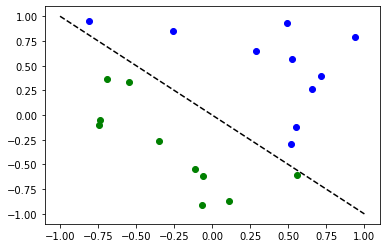

In [32]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with the an `OpflowQNN`

First we show how an `OpflowQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `OpflowQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to $\{-1, +1\}$. For convenience, we use the `TwoLayerQNN`, which is a special type of `OpflowQNN` defined via a feature map and an ansatz.

In [33]:
# construct QNN
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

In [34]:
# QNN maps inputs to [-1, +1]
opflow_qnn.forward(X[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[0.32617187]])

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [35]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [36]:
# construct neural network classifier
opflow_classifier = NeuralNetworkClassifier(opflow_qnn, optimizer=COBYLA(), callback=callback_graph)

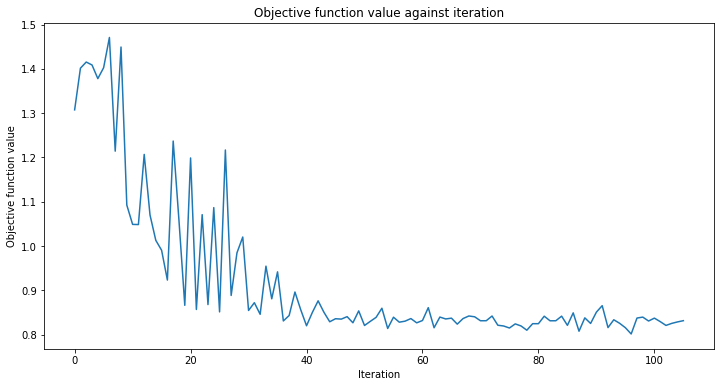

0.7

In [37]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X, y)

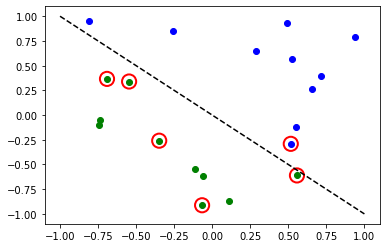

In [38]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Now, when the model is trained, we can explore the weights of the neural network. Please note, the number of weights is defined by ansatz. In case of `TwoLayerQNN` and when no ansatz is passed, it is a `RealAmplitudes` quantum circuit.

In [39]:
opflow_classifier.weights

array([ 0.85652538, -0.27213463, -1.80021795,  0.15175744,  0.52731015,
        0.85434007,  3.77529791, -1.11462516])

### Classification with a `CircuitQNN`

Next we show how a `CircuitQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `CircuitQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. Sampling from a `QuantumCircuit` automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

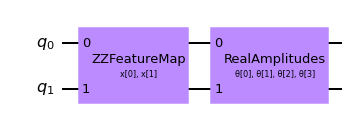

In [40]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

In [41]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [42]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

In [43]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

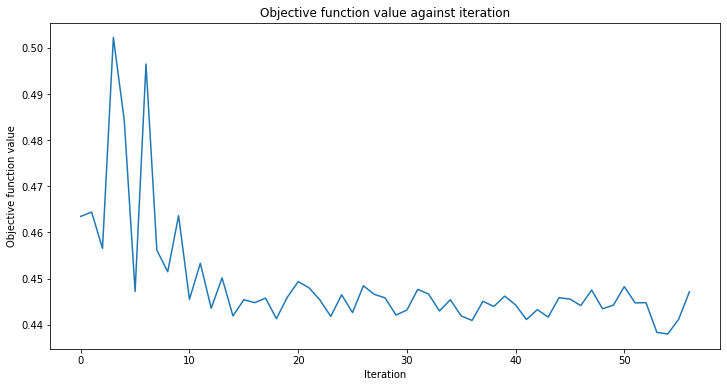

0.65

In [44]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(X, y01)

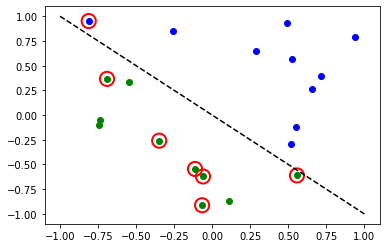

In [45]:
# evaluate data points
y_predict = circuit_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Again, once the model is trained we can take a look at the weights. As we set `reps=1` explicitly in our ansatz, we can see less parameters than in the previous model.

In [47]:
circuit_classifier.weights

array([ 0.61187604,  1.393702  , -0.53822264,  0.02282859])

### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `CircuitQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [48]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

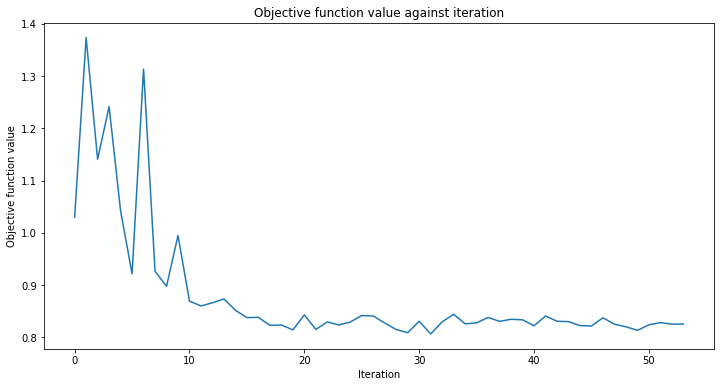

0.8

In [49]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

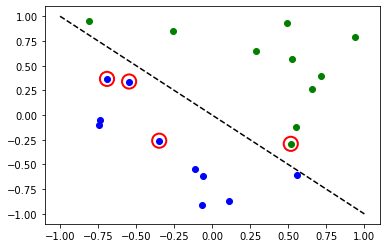

In [50]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

## Regression

We prepare a simple regression dataset to illustrate the following algorithms.

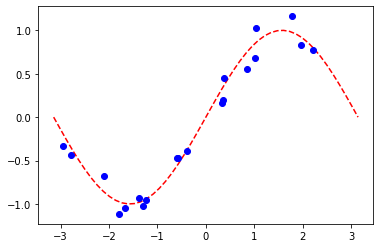

In [52]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

### Regression with an `OpflowQNN`

Here we restrict to regression with an `OpflowQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `CircuitQNN` but that exceeds the scope of this tutorial.

In [53]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)

In [54]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(),
    callback=callback_graph,
)

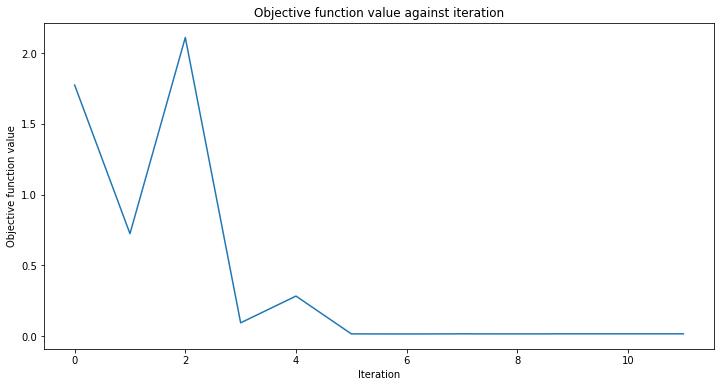

0.9725820458049627

In [55]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

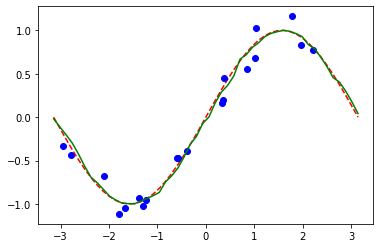

In [56]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

Similarly to the classification models, we can obtain an array of trained weights by querying a corresponding property of the model. In this model we have only one parameter defined as `param_y` above.

In [58]:
regressor.weights

array([-1.59820869])

### Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with a `OpflowQNN`. By default it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [24]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

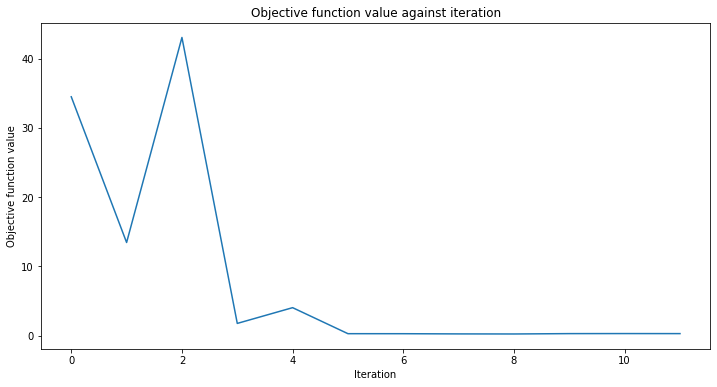

0.9748043399155905

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

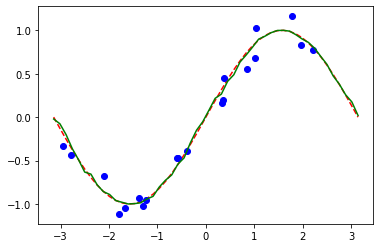

In [26]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [28]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright